## Whiskey Recommendataion

The goal of this presentation is to analyze Whiskey Dataset and to provide sensible insights into the data, as well as to recommend most similar whiskey to the one picked by a user.

Recruitment task for Schneider Electric
Aleksei Haidukevich
28.01.2025

All code and insights belong to the author of this notebook, no AI used except for formatting purposes.

**The Q&A section at the end of this notebooks provides the answers to the recruiter's questions.**


## Dependencies

Pandas library is used over PySpark because of the additional time required to configure PySpark cluster properly. The environment is Google Colab.

In [1]:
import pandas as pd
from sklearn import manifold
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

#### Orignal Data

In [2]:
df0 = pd.read_excel("scotch.xlsx", engine='openpyxl')
df0 = df0.rename(columns={col: new_col.lstrip().rstrip() for col, new_col in zip(df0.columns,
    ['NAME','NAME2','color wyne','color yellow','color v.pale','color pale','color p.gold','color gold','color o.gold','color f.gold','color bronze','color p.amber','color amber','color f.amber','color red','color sherry','NOSE AROMA','NOSE PEAT','NOSE SWEET','NOSE LIGHT','NOSE FRESH','NOSE DRY','NOSE FRUIT','NOSE GRASS','NOSE SEA','NOSE SHERRY','NOSE SPICY','NOSE RICH','BODY soft','BODY med','BODY full','BODY round','BODY smooth','BODY light','BODY firm','BODY oily','PAL full','PAL dry','PAL sherry','PAL big','PAL light','PAL smooth','PAL clean','PAL fruit','PAL grass','PAL smoke','PAL sweet','PAL spice','PAL oil','PAL salt','PAL arome','FIN full','FIN dry','FIN warm','FIN big','FIN light','FIN smooth','FIN clean','FIN fruit','FIN grass','FIN smoke','FIN sweet','FIN spice','FIN oil','FIN salt','FIN arome','FIN ling','FIN long','FIN very','FIN quick',' AGE',' DIST',' SCORE',' %',' REGION',' DISTRICT',' islay',' midland',' spey',' east',' west',' north ',' lowland',' campbell','islands'])})
df0 = df0.iloc[1:-2]
df0 = df0.drop(['NAME2', 'AGE', 'SCORE'], axis=1)
df0.head()

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,NAME,color wyne,color yellow,color v.pale,color pale,color p.gold,color gold,color o.gold,color f.gold,color bronze,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
1,Aberfeldy,0,1,0,0,0,0,0,0,0,...,MIDLAND,0,1,0,0,0,0,0,0,0
2,Aberlour,0,0,0,0,0,0,0,0,0,...,SPEY,0,0,1,0,0,0,0,0,0
3,Ardberg,0,0,0,0,0,0,0,0,0,...,SOUTH,1,0,0,0,0,0,0,0,0
4,Ardmore,0,0,0,0,1,0,0,0,0,...,SPEY,0,0,1,0,0,0,0,0,0
5,Auchentoshan,0,0,0,0,1,0,0,0,0,...,WEST,0,0,0,0,0,0,1,0,0


#### Geo Distance

In [3]:
geo = {}
with open('DIST-GEO.TXT', 'r') as f:
    lines = f.read().split('\n')
    nameid = 1
    for i in range(0, len(lines)-1, 14):
        try:
            geo[df0.NAME[nameid]] = ''.join(lines[i:(i + 14)]).lstrip().rstrip().split('  ')
            nameid += 1
        except:
            break

dg = pd.DataFrame(geo)
dg.index = dg.columns
dg = dg.astype(float)
dg = (1.0 - (dg / dg.values.max())).round(4)
dg.head()

,Aberfeldy,Aberlour,Ardberg,Ardmore,Auchentoshan,Aultmore,Balblair,Balmenach,Balvenie,Banff,...,Strathisla,Talisker,Tamdhu,Tamnavulin,Teaninich,Tobermory,Tomatin,Tomintoul,Tormore,Tullibardine
Aberfeldy,1.0000,0.7778,0.5062,0.7160,0.8148,0.7284,0.7407,0.7778,0.7654,0.6420,...,0.7284,0.4691,0.7901,0.8148,0.7654,0.5432,0.8519,0.8395,0.8148,0.9259
Aberlour,0.7778,1.0000,0.3086,0.8889,0.6049,0.9506,0.7901,0.9753,0.9753,0.8519,...,0.9383,0.3580,0.9753,0.9630,0.7778,0.3827,0.8395,0.9506,0.9630,0.7284
Ardberg,0.5062,0.3086,1.0000,0.2222,0.6420,0.2469,0.4074,0.2963,0.2840,0.1605,...,0.2469,0.6543,0.3210,0.3333,0.4444,0.8025,0.4444,0.3580,0.3457,0.5062
Ardmore,0.7160,0.8889,0.2222,1.0000,0.5432,0.9136,0.6790,0.9012,0.9136,0.9259,...,0.9259,0.2469,0.8642,0.8642,0.6667,0.2840,0.7284,0.8519,0.8519,0.6790
Auchentoshan,0.8148,0.6049,0.6420,0.5432,1.0000,0.5556,0.6049,0.5926,0.5926,0.4691,...,0.5556,0.5062,0.6173,0.6420,0.6420,0.6296,0.6914,0.6543,0.6420,0.8519


#### Coordinates

In [4]:
coor = []
with open('DISTCOOR.TXT', 'r') as f:
    for line in f.read().split('\n')[7:]:
        if line != '':
            dots = [i for i, char in enumerate(line) if char == "."]
            d1, d2 = dots[0]-2, dots[1]-3
            name, longit, latit = line[:d1].strip(), float(line[d1:d2].strip()), float(line[d2:].strip())
            coor.append([name, longit, latit])
dc = pd.DataFrame(coor, columns=["NAME", "long", "lat"])
dc.head()

,NAME,long,lat
0,Aberfeldy,3.875,56.62
1,Aberlour,3.220,57.46
2,Ardberg,6.080,55.64
3,Ardmore,2.670,57.32
4,Auchentoshan,4.390,55.91


## Data Quality

We should pay special attention to the data quality and integrity. We make sure that no gaps are present in the dataset. Then we should check if no whiskey is assigned two colors (this info allows us to aggregate the color columns into a singular category column).

In [5]:
df = df0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 1 to 109
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   NAME           109 non-null    object
 1   color wyne     109 non-null    object
 2   color yellow   109 non-null    object
 3   color v.pale   109 non-null    object
 4   color pale     109 non-null    object
 5   color p.gold   109 non-null    object
 6   color gold     109 non-null    object
 7   color o.gold   109 non-null    object
 8   color f.gold   109 non-null    object
 9   color bronze   109 non-null    object
 10  color p.amber  109 non-null    object
 11  color amber    109 non-null    object
 12  color f.amber  109 non-null    object
 13  color red      109 non-null    object
 14  color sherry   109 non-null    object
 15  NOSE AROMA     109 non-null    object
 16  NOSE PEAT      109 non-null    object
 17  NOSE SWEET     109 non-null    object
 18  NOSE LIGHT     109 non-null   

In [7]:
df.describe()

,NAME,color wyne,color yellow,color v.pale,color pale,color p.gold,color gold,color o.gold,color f.gold,color bronze,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
count,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
unique,109,2,2,2,2,2,2,2,2,2,...,15,2,2,2,2,2,2,2,2,2
top,Aberfeldy,0,0,0,0,0,0,0,0,0,...,SPEY,0,0,1,0,0,0,0,0,0
freq,1,101,107,107,105,99,88,107,82,104,...,57,102,103,57,99,104,102,100,106,104


In [8]:
color_columns = [col for col in df.columns if col.startswith('color')]
df[color_columns].sum(axis=1).value_counts()

,count
1,109


## Processing & Exploration

#### Color One-hot Encoding

We turn colors into a singe column and encode it.

In [9]:


dict_region = {r:i for i, r in enumerate(df.REGION.unique())}
dict_color = {c.split(' ')[-1]:i for c, i in  zip(color_columns, range(len(color_columns)))}
dict_district = {r:i for i, r in enumerate(df.DISTRICT.unique())}

colors = []

code_COLOR = []
code_DISTRICT = []
code_REGION = []


for index, row in df.iterrows():

    code_REGION.append(dict_region[row.REGION])
    code_DISTRICT.append(dict_district[row.DISTRICT])


    for col in color_columns:
        if row[col] == 1:

            colors.append(col.split(' ')[-1])
            code_COLOR.append(dict_color[col.split(' ')[-1]])
df.drop(color_columns, axis=1, inplace=True)

df['COLOR'] = colors
df['code_COLOR'] = code_COLOR
df['code_REGION'] = code_REGION
df['code_DISTRICT'] = code_DISTRICT

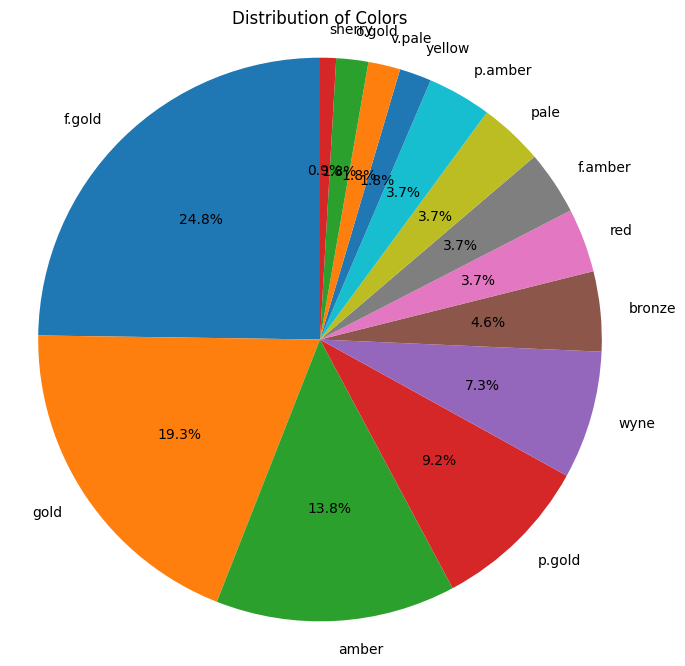

In [10]:
color_counts = df['COLOR'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(color_counts, labels=color_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Colors')
plt.axis('equal')
plt.show()

## Features

The main question is to which features to check, and which features would affect the recommendations the most. We could either focus on the taste columns, color feature and/or the geographical positions.

After careful examination taste-related features were selected for recommendation, as well as the features about color, region and district.

In [11]:
df.head()

,NAME,NOSE AROMA,NOSE PEAT,NOSE SWEET,NOSE LIGHT,NOSE FRESH,NOSE DRY,NOSE FRUIT,NOSE GRASS,NOSE SEA,...,east,west,north,lowland,campbell,islands,COLOR,code_COLOR,code_REGION,code_DISTRICT
1,Aberfeldy,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,yellow,1,0,0
2,Aberlour,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,red,12,0,1
3,Ardberg,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,sherry,13,1,2
4,Ardmore,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,p.gold,4,0,1
5,Auchentoshan,0,0,0,0,1,0,1,1,0,...,0,0,0,1,0,0,p.gold,4,2,3


In [12]:
F_taste = list(df.columns[1:55])
# F = F_taste
# F = ["code_COLOR"] + F_taste
F = ["code_COLOR", "code_DISTRICT", "code_REGION"] + F_taste

N = len(F)
N

57

## Similarity

In [13]:
def similarity(row1, row2):
    return round((row1[F] == row2[F]).sum() / N, 4)

In [14]:
dist = {name: [] for name in df.NAME}
for (indx1, row1) in df.iterrows():
    for (indx2, row2) in df.iterrows():
        dist[row1.NAME].append(similarity(row1, row2))
dd = pd.DataFrame(dist)
dd.index = dd.columns
dd.head()

,Aberfeldy,Aberlour,Ardberg,Ardmore,Auchentoshan,Aultmore,Balblair,Balmenach,Balvenie,Banff,...,Strathisla,Talisker,Tamdhu,Tamnavulin,Teaninich,Tobermory,Tomatin,Tomintoul,Tormore,Tullibardine
Aberfeldy,1.0000,0.6316,0.6667,0.6316,0.7018,0.7193,0.7193,0.7368,0.7368,0.7719,...,0.6667,0.6140,0.7018,0.6842,0.7368,0.6842,0.7018,0.7018,0.7193,0.6140
Aberlour,0.6316,1.0000,0.6491,0.7018,0.6491,0.6842,0.7018,0.7018,0.7368,0.7018,...,0.7018,0.6842,0.7018,0.6842,0.6842,0.6667,0.7368,0.7018,0.6842,0.7193
Ardberg,0.6667,0.6491,1.0000,0.7193,0.6667,0.7018,0.7018,0.7193,0.7193,0.7544,...,0.7193,0.7018,0.7544,0.7368,0.7193,0.6667,0.7193,0.7193,0.7368,0.6842
Ardmore,0.6316,0.7018,0.7193,1.0000,0.7719,0.7193,0.7018,0.7544,0.7368,0.7368,...,0.7719,0.7719,0.7719,0.7895,0.6491,0.6667,0.7018,0.8070,0.6842,0.7544
Auchentoshan,0.7018,0.6491,0.6667,0.7719,1.0000,0.7719,0.7719,0.7368,0.7193,0.7193,...,0.6491,0.6316,0.6491,0.7719,0.6491,0.6667,0.6842,0.7895,0.6316,0.6842


## Clustering

We separate the data into 5 clusters using KMeans unsupervised learning algorithm, as well as the famous elbow method to find the best number of clusters.

The main plot of this section uses the visualisation technique known as Multidimensional Scaling (MDS) so that the multiple features can be projected onto 2D plane. It shows us characteristic clusters of the whiskey distilleries. This label is assigned to be a distillery's "class".

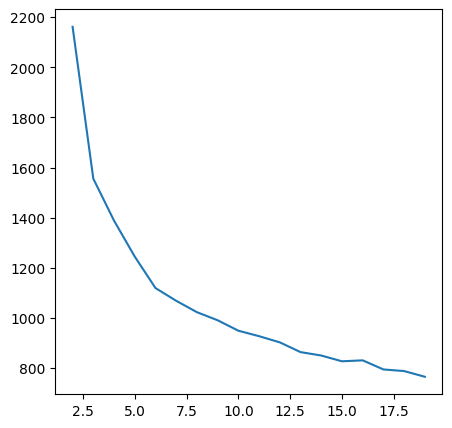

In [16]:
inert = []

for i in range(2,20):
    km = KMeans(n_clusters = i, n_init=10, max_iter = 500, random_state =0)
    km.fit(df.loc[:, F])
    inert.append(km.inertia_)

plt.figure(figsize=(5, 5))
plt.plot(range(2,20),inert)
plt.show()

In [17]:
km = KMeans(n_clusters = 5, n_init=10, max_iter = 300, random_state =0)
df['class'] = km.fit_predict(df.loc[:, F])
df['class'].values

array([0, 1, 1, 4, 4, 0, 0, 4, 1, 1, 1, 4, 1, 1, 0, 4, 3, 4, 3, 4, 0, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4, 3, 1, 0, 4, 3, 4, 4, 1, 1,
       3, 1, 0, 3, 4, 1, 1, 1, 3, 4, 1, 1, 4, 4, 4, 1, 1, 3, 4, 0, 0, 3,
       3, 2, 1, 4, 1, 4, 3, 1, 4, 4, 0, 1, 1, 1, 3, 3, 2, 4, 1, 1, 4, 1,
       3, 1, 1, 1, 2, 2, 2, 1, 1, 3, 3, 1, 2, 1, 0, 1, 2, 1, 4, 1, 4],
      dtype=int32)

In [18]:
dd["class"] = df["class"].values
dg["class"] = df["class"].values

<ipython-input-19-0696574c37c9>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


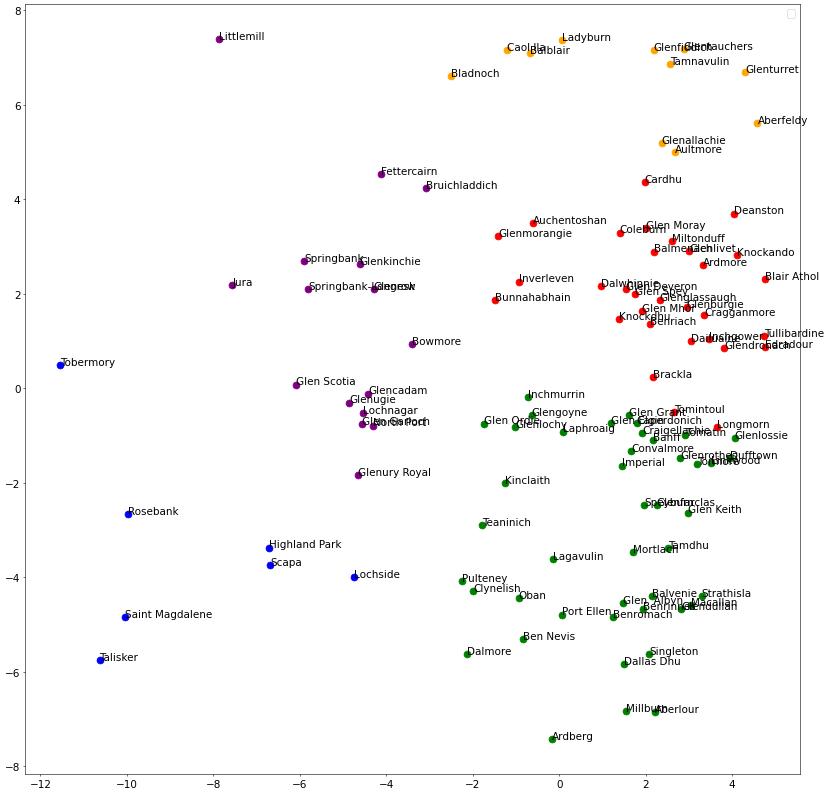

In [19]:
mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=0)
pos = mds.fit_transform(df.loc[:, F])

col =['orange','green', 'blue', 'purple', 'red']

labels = df['NAME']

plt.figure(figsize=(20, 20), dpi=50)
plt.rcParams["font.size"] = 15


for label, x, y, c in zip(labels, pos[:, 0], pos[:, 1], df['class']):

    plt.scatter(x,y, c=col[c], s=100)

    plt.annotate(label,xy = (x, y))
plt.legend(loc='upper right')
plt.show()

#### Class-Color Distribution

We can see that the cluster-wise distribution also affects the distribution of the color variable. It is most prominent in clusters 1 and 3, which focus mostly on "wyne" and "amber" values, while the overall distribution in the population focuses mostly on gold colors.

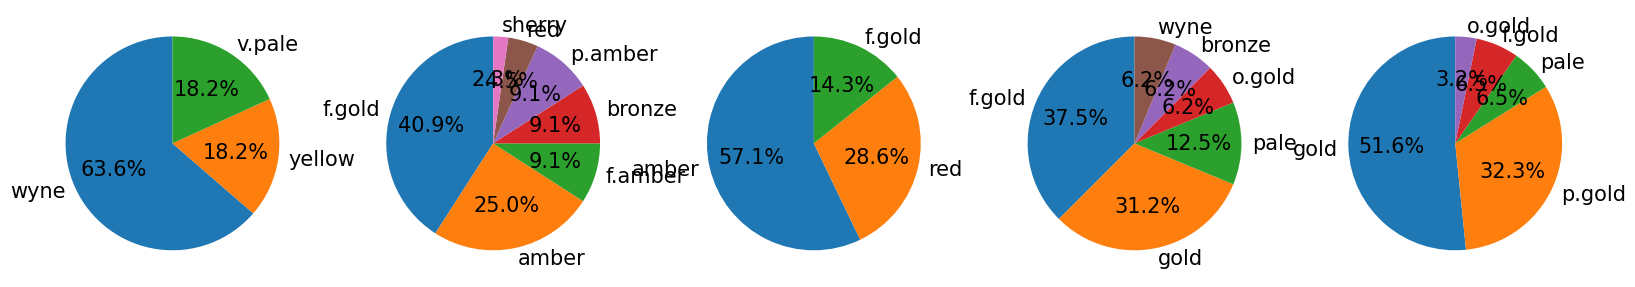

In [20]:
plt.figure(figsize=(20, 6))

for i in range(5):
    plt.subplot(1, 5, 1+i)
    counts = df[df['class'] == i]['COLOR'].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)

#### Geo Distribution

The following scatter plot demonstrates that the variables that describe the geoprahical position of the distillery do now necessairly corellate with the predicted class, so it is safe to assume that the latitute and longitude of the distillery does not affect the recommendation sensibly.

<ipython-input-21-8c1503fb84c5>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


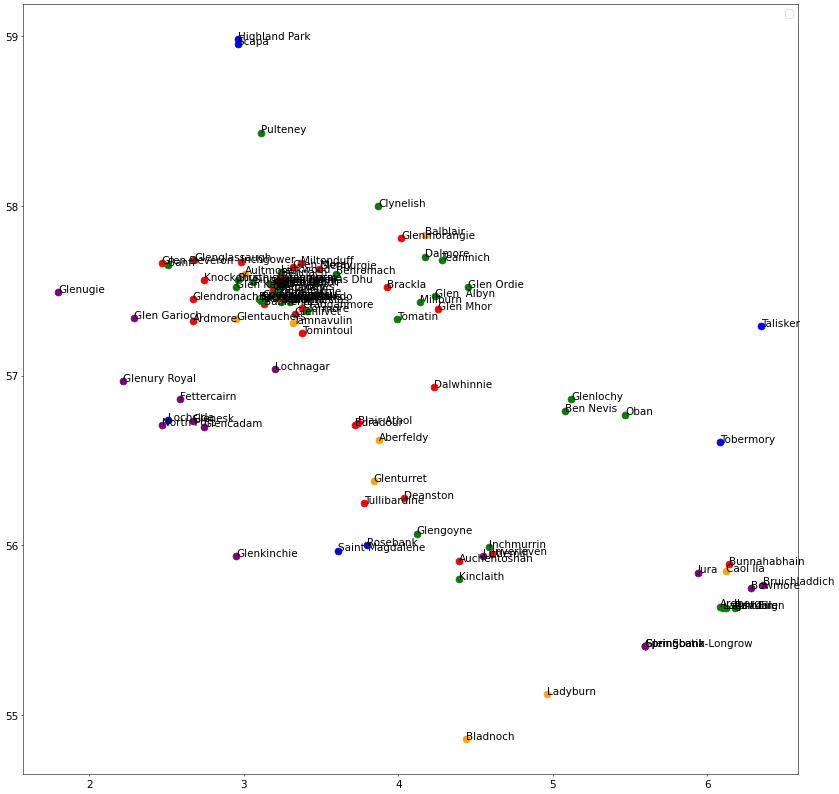

In [21]:

col =['orange','green', 'blue', 'purple', 'red']

labels = df['NAME']

plt.figure(figsize=(20, 20), dpi=50)
plt.rcParams["font.size"] = 15

for label, x, y, c in zip(labels, dc["long"], dc["lat"], df['class']):

    plt.scatter(x,y, c=col[c], s=100)

    plt.annotate(label,xy = (x, y))
plt.legend(loc='upper right')
plt.show()

## Recommendations

We use the similarity matrix, build with the chosen features to recommend the whiskey similar to the chosen. The code displays top5 simialar distilleries. We can use the class knowledge to check that our assumptions about the feature corellations were safe.

For more info see Q&A section.

In [22]:
chosen_name = "Jura"

In [23]:
dd[[chosen_name, "class"]].sort_values(chosen_name, ascending=False).head(6)

,Jura,class
Jura,1.0000,3
Glenfarclas,0.8070,1
North Port,0.7895,3
Glenesk,0.7895,3
Tamdhu,0.7895,1
Glen Albyn,0.7719,1


In [24]:
dg[[chosen_name, "class"]].sort_values(chosen_name, ascending=False).head(5)

,Jura,class
Jura,1.0000,3
Caol Ila,0.9630,0
Bunnahabhain,0.9630,4
Lagavulin,0.9506,1
Ardberg,0.9506,1


## Questions & Answers

---

Q. What interesting information user can find in the dataset?

A. After analyzing the original data, as well as the geo distribution, user might notice that the geographical location doesn't correlate much with the whiskey's properties. It is also interesting that this region mostly focuses on gold and amber sorts.

---

Q. Choose whisky name and find other whisky(-ies) which you might like as well; Please provide reasoning of your steps.

A. The **Recommendations** section suggests top 5 whiskeys similar to the chosen one. The metric here is the similarity of taste features, as well as the features such as region, district and color.  

If we want to encorporate the label data into the recommendation, we can assemble an approach when we recommend only the whiskey from the corresponding cluster.

---

Q. How chosen whisky(-ies) can be perceived vs. other types?

A. There're number of ways how we can compare a specific distillary to the others. We can either use a similarity metric defined in this notebook, which looks for intersections of the chosen features' values. Or, we can take into accound the geographical positions of the distillaries, under the assumption that similar regions would produce similar results - which, it turns out, not a reliable way to find similar whiskeys. Finally, we can aggregate data points into clusters and assign each whiskey a label, which encapsulates the information of how similar this distillery is to its competitors.

---

Q. What factors impact results the most?

A. After the careful analysis the conclusion can be made that the **color** property of the whiskey affects the recommendation the most, but at the same time features that describe **taste** add to the full picture, and the recommendation won't be completely precise without taking them into account.